# Q3: How Robust Credit Risk Models are Over Time

This script compares Naive Bayes, Support Vector Machines, Decision Trees, K-Nearest Neighbours, and a Binary Classifier Neural Network in their performance in credit risk prediction when trained and tested data differ in economic periods. The dataset used is that of https://www.kaggle.com/datasets/wordsforthewise/lending-club/data, where the economic periods detailed are between 2007 to 2018. The usable data is split in half to form two periods, periods 1 and 2. All models will be trained on period 1 and tested on period 2. The results of each model are then compared to analyse temporal stability. The classification models were developed to determine whether a candidate would have a low or high credit risk.  

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import json
from pathlib import Path
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Add project root to path
PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))
warnings.filterwarnings("ignore")

Q3_DATA_PATH = Path("..") / "assets" / "q3_data"
Q3_DATA_CHUNKS_PATH = Q3_DATA_PATH / "yearly_samples"

from data_processings.datasets import LendingClubDataset
from models.neural import BinaryClassifier

## Pre-Processing of Data

**Building Yearly Samples**

The Lending Club Dataset contains millions of samples, which can be very computationally expensive. Due to this, the dataset is iterated through chunks. Then, yearly samples are taken and stored in pickle files. Samples per year are constrained to support memory and time efficiency. 

*Note: Although the data spans from 2007 to 2018, after filtering through features and removing incomplete data (as seen in datasets.py and feature_engineering.py) Usable data spans from 2012 to 2018. Due to this, data from 2012 to 2015 and 2016 to 2018 are denoted as periods 1 and 2, respectively. Feature engineering is included in build_yearly_samples().*

In [2]:
chunk_size = 5000
samples_per_year = 5000
dataloader = LendingClubDataset()
dataloader.build_yearly_samples(chunk_size, samples_per_year, Q3_DATA_CHUNKS_PATH)

Chunk 1 in progress!
Chunk 2 in progress!
Chunk 3 in progress!
Chunk 4 in progress!
Chunk 5 in progress!
Chunk 6 in progress!
Chunk 7 in progress!
Chunk 8 in progress!
Chunk 9 in progress!
Chunk 10 in progress!
Chunk 11 in progress!
Chunk 12 in progress!
Chunk 13 in progress!
Chunk 14 in progress!
Chunk 15 in progress!
Chunk 16 in progress!
Chunk 17 in progress!
Chunk 18 in progress!
Chunk 19 in progress!
Chunk 20 in progress!
Chunk 21 in progress!
Chunk 22 in progress!
Chunk 23 in progress!
Chunk 24 in progress!
Chunk 25 in progress!
Chunk 26 in progress!
Chunk 27 in progress!
Chunk 28 in progress!
Chunk 29 in progress!
Chunk 30 in progress!
Chunk 31 in progress!
Chunk 32 in progress!
Chunk 33 in progress!
Chunk 34 in progress!
Chunk 35 in progress!
Chunk 36 in progress!
Chunk 37 in progress!
Chunk 38 in progress!
Chunk 39 in progress!
Chunk 40 in progress!
Chunk 41 in progress!
Chunk 42 in progress!
Chunk 43 in progress!
Chunk 44 in progress!
Chunk 45 in progress!
Chunk 46 in progres

**Yearly DataFrames**

In [3]:
yearly_df = {}
start_year = 2012
end_year = 2018

for i in range(end_year - start_year + 1):
    path = os.path.join(Q3_DATA_CHUNKS_PATH, f"lending_club_{start_year+i}.pkl")

    df = pd.read_pickle(path)

    key = f"{start_year+i}"

    yearly_df[key] = df

    class_dist_report = ", ".join(f"{j}: {k}" for j, k in df['loan_status'].value_counts(normalize=True).items())

    print(f"{key}: {len(df)} rows with a class distribution of [{class_dist_report}]")

print("Where: \nFully Paid -> Low Credit Risk \nCharged Off -> High Credit Risk")


2012: 5000 rows with a class distribution of [Fully Paid: 0.5, Charged Off: 0.5]
2013: 5000 rows with a class distribution of [Charged Off: 0.5, Fully Paid: 0.5]
2014: 5000 rows with a class distribution of [Charged Off: 0.5, Fully Paid: 0.5]
2015: 5000 rows with a class distribution of [Charged Off: 0.5, Fully Paid: 0.5]
2016: 5000 rows with a class distribution of [Charged Off: 0.5, Fully Paid: 0.5]
2017: 5000 rows with a class distribution of [Charged Off: 0.5, Fully Paid: 0.5]
2018: 5000 rows with a class distribution of [Charged Off: 0.5, Fully Paid: 0.5]
Where: 
Fully Paid -> Low Credit Risk 
Charged Off -> High Credit Risk


**Train-Test Split Based on Economic Periods: Period 1 (Train) and Period (Test)**

*where: Period 1 (2012-2015) and Period 2 (2016-2018)*

In [4]:
year_indicator_col = 'issue_year'
target_col = 'loan_status'
cut_off_year = 2015 
train_dfs = []
test_dfs = []

for year, df in yearly_df.items():
    if int(year) <= cut_off_year:
        train_dfs.append(df)
        print(f"{year} added to the train DataFrame!")
    else:
        test_dfs.append(df)
        print(f"{year} added to the test DataFrame!")

train_df = pd.concat(train_dfs, ignore_index=True)
train_df = train_df.sample(frac=1, random_state=50).reset_index(drop=True)
test_df = pd.concat(test_dfs, ignore_index=True)
test_df = test_df.sample(frac=1, random_state=50).reset_index(drop=True)

2012 added to the train DataFrame!
2013 added to the train DataFrame!
2014 added to the train DataFrame!
2015 added to the train DataFrame!
2016 added to the test DataFrame!
2017 added to the test DataFrame!
2018 added to the test DataFrame!


**Binary Mapping, One Hot Encoding, and Alignment**

In [5]:
def map_encode(df: pd.DataFrame):
    # Binary Mapping for Binary Categorical Features
    df = df.drop(columns=['issue_year', 'issue_month'])
    df['emp_length'] = df['emp_length'].str.extract('(\d+)').fillna(0).astype(int)
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # Remove leading and trailing spaces
    df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1}) # Where Fully Paid -> Low Risk and Charged Off -> High Risk
    df['application_type'] = df['application_type'].map({'Individual': 0, 'Joint App': 1})
    df['term'] = df['term'].map({'36 months': 0, '60 months': 1})

    # One Hot Encoding for Non-Binary Categorical Features 
    categorical_features = ['verification_status']
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True, dtype=int)

    return df

train_df = map_encode(train_df)
test_df = map_encode(test_df)

train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)
feature_names = [c for c in train_df.columns if c != 'loan_status']

**Preview of Processed Train and Test DataFrames**

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [6]:
train_df.head()

,loan_status,revol_util,emp_length,term,application_type,int_rate,delinq_2yrs,acc_now_delinq,acc_open_past_24mths,pub_rec,dti_mod,annual_inc_mod,loan_income_ratio,fico_mean,verification_status_Source Verified,verification_status_Verified
0,0,5.1,10,0,0,10.99,0.0,0.0,1.0,0.0,10.47,54000.0,0.120370,772.0,0,0
1,1,96.5,8,0,0,18.75,0.0,0.0,9.0,0.0,20.74,32000.0,0.328125,672.0,1,0
2,1,71.9,7,1,0,16.24,0.0,0.0,9.0,0.0,19.54,59580.0,0.335683,702.0,1,0
3,1,62.8,2,0,0,14.98,0.0,0.0,4.0,0.0,8.14,146000.0,0.037671,682.0,1,0
4,0,34.7,8,0,0,11.48,2.0,0.0,10.0,0.0,15.29,185000.0,0.086486,672.0,0,0


In [7]:
test_df.head()

,loan_status,revol_util,emp_length,term,application_type,int_rate,delinq_2yrs,acc_now_delinq,acc_open_past_24mths,pub_rec,dti_mod,annual_inc_mod,loan_income_ratio,fico_mean,verification_status_Source Verified,verification_status_Verified
0,1,57.8,1,1,1,16.02,0.0,0.0,8.0,0.0,28.65,90000.0,0.566667,692.0,1,0
1,0,64.4,10,1,0,27.49,0.0,0.0,8.0,2.0,27.20,50000.0,0.384000,697.0,0,1
2,1,31.1,2,0,0,14.08,0.0,0.0,12.0,0.0,8.78,51000.0,0.196078,662.0,0,1
3,0,26.8,5,0,0,13.49,0.0,0.0,14.0,0.0,8.42,65000.0,0.015385,707.0,1,0
4,0,28.5,3,0,0,9.49,0.0,0.0,3.0,0.0,25.90,55000.0,0.054545,757.0,0,0


**Verify Data Types per Column**

In [8]:
for col, dtype in train_df.dtypes.items():
    print(f"{col}: {dtype}")

loan_status: int64
revol_util: float64
emp_length: int64
term: int64
application_type: int64
int_rate: float64
delinq_2yrs: float64
acc_now_delinq: float64
acc_open_past_24mths: float64
pub_rec: float64
dti_mod: float64
annual_inc_mod: float64
loan_income_ratio: float64
fico_mean: float64
verification_status_Source Verified: int64
verification_status_Verified: int64


**Split to Target and Features**

In [9]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

In [ ]:
y_test.value_counts()

In [ ]:
y_train.value_counts()

In [ ]:
# Check the distribution of features
print("Describe:")
print(X_train.describe())

# Check unique values
print("Unique:")
print(X_train.nunique())

# Check for NaNs
print("isNaN:")
print(X_train.isna().sum())

# Check y_train
print("Value Counts:")
print(y_train.value_counts())

**Scaling with MinMaxScaler()**

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
X_train

In [ ]:
X_test

In [ ]:
print(np.unique(y_train))

## Model Training and Evaluation

**Initializations and Functions**

In [11]:
class_mapping = {0: 'Low Risk',
                 1: 'High Risk'}

def dict_to_json(data : dict, folder_path: str, file_name: str):
    file_name = f"{file_name}.json"
    file_path = os.path.join(folder_path, file_name)
    os.makedirs(folder_path, exist_ok=True)

    with open(file_path, "w") as f:
        json.dump(data, f, indent=4)

    print(f"JSON file is saved to {file_path}!")

def conmat_to_png(conmat, class_mapping: dict, folder_path: str, file_name: str, model_name: str):

    file_name = f"{file_name}.png"
    file_path = os.path.join(folder_path, file_name)
    os.makedirs(folder_path, exist_ok=True)

    class_labels = list(class_mapping.values())
    
    fig = plt.figure(figsize=(15, 10))
    axis = sns.heatmap(conmat, annot=True, fmt='0.2f', cbar=True, xticklabels=class_labels, yticklabels=class_labels)
    
    axis.set_ylabel("True Values")

    axis.set_xlabel("Predicted Values")

    title = f"Normalized Confusion Matrix for {model_name}"

    axis.set_title(title)

    fig.savefig(file_path)

    print(f"PNG file is saved to {file_path}!")

**Model 1: Naive Bayes**

Training

In [12]:
GNB = GaussianNB()
GNB.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


Evaluation

Naive Bayes Accuracy: 0.6206666666666667
JSON file is saved to ..\assets\q3_data\gnb_performance.json!
PNG file is saved to ..\assets\q3_data\gnb_confusion_matrix.png!


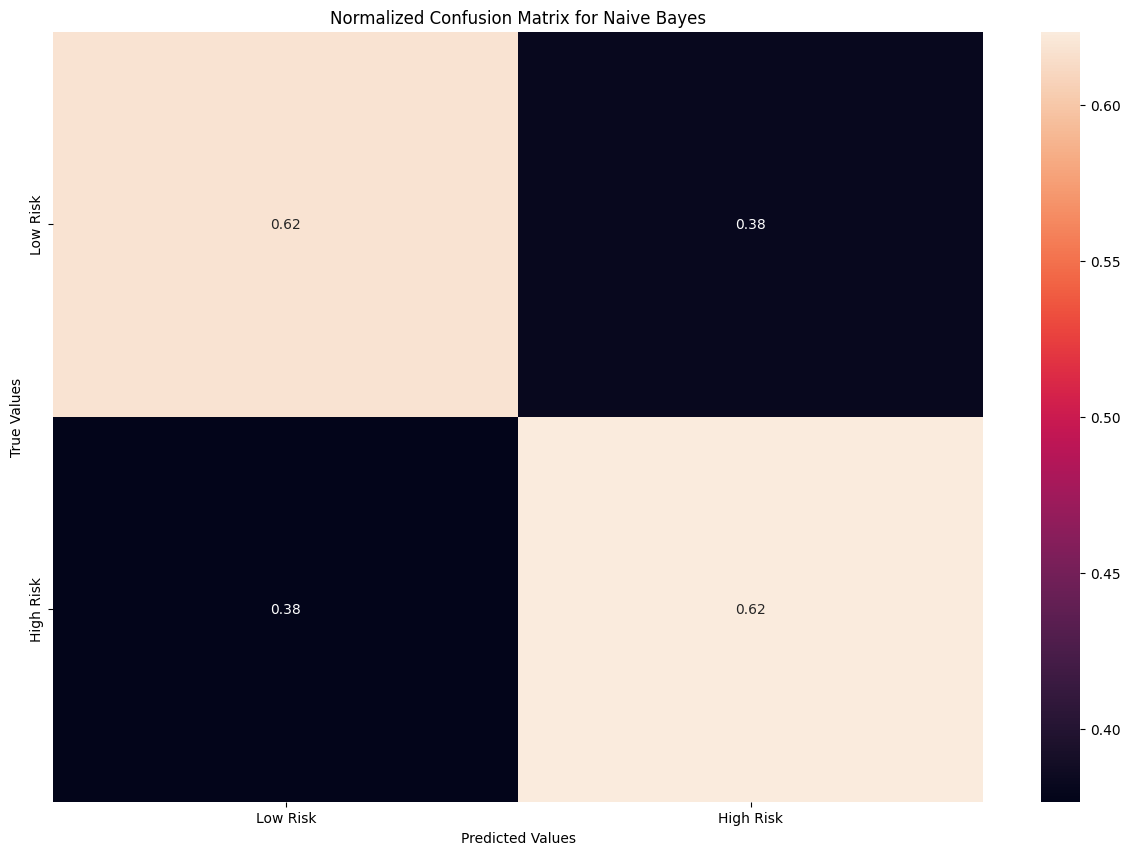

In [13]:
GNB_preds = GNB.predict(X_test)
GNB_summary = classification_report(y_true=y_test, y_pred=GNB_preds, labels=list(class_mapping.keys()), target_names=list(class_mapping.values()), output_dict=True)

print(f"Naive Bayes Accuracy: {GNB_summary['accuracy']}")

GNB_file_name = "gnb_performance"
dict_to_json(GNB_summary, Q3_DATA_PATH, GNB_file_name)

GNB_conmat = confusion_matrix(y_test, GNB_preds, normalize='true')

GNB_conmat_name = "gnb_confusion_matrix"
GNB_model_name = "Naive Bayes"
conmat_to_png(GNB_conmat, class_mapping, Q3_DATA_PATH, GNB_conmat_name, GNB_model_name)

**Model 2: Support Vector Machine**

Training

In [27]:
C_vals = [0.01, 0.1, 1.0, 10.0]
best_accuracy = 0
best_SVM = SVC(C=1)
best_C = 0
SVM_accuracies = []

for i in range(len(C_vals)):
    SVM_candidate = SVC(kernel='linear', C=C_vals[i], random_state=10)

    print(f"Training SVM with C Value of {C_vals[i]}")
    SVM_candidate.fit(X_train, y_train)

    SVM_candidate_preds = SVM_candidate.predict(X_test)

    SVM_candidate_acc = round(accuracy_score(y_test, SVM_candidate_preds), 5)
    SVM_accuracies.append(SVM_candidate_acc)

    if SVM_candidate_acc > best_accuracy:
        best_SVM = SVM_candidate
        best_C = C_vals[i]
        best_accuracy = SVM_candidate_acc
    
    print(f"SVM with C Value of {C_vals[i]} was tested and had an accuracy of {SVM_candidate_acc}!")

SVM = best_SVM

print(f"Best C Value: {best_C}")
print(f"Accuracy: {best_accuracy}")

Training SVM with C Value of 0.01
SVM with C Value of 0.01 was tested and had an accuracy of 0.62413!
Training SVM with C Value of 0.1
SVM with C Value of 0.1 was tested and had an accuracy of 0.62453!
Training SVM with C Value of 1.0
SVM with C Value of 1.0 was tested and had an accuracy of 0.6248!
Training SVM with C Value of 10.0
SVM with C Value of 10.0 was tested and had an accuracy of 0.6248!
Best C Value: 1.0
Accuracy: 0.6248


In [30]:
SVM_explore_dict = {
    'C': C_vals,
    'accuracies': SVM_accuracies
}

SVM_exp_file_name = "svm_exploration"
dict_to_json(SVM_explore_dict, Q3_DATA_PATH, SVM_exp_file_name)

JSON file is saved to ..\assets\q3_data\svm_exploration.json!


Evaluation

Support Vector Machine Accuracy: 0.6248
JSON file is saved to ..\assets\q3_data\svm_performance.json!
PNG file is saved to ..\assets\q3_data\svm_confusion_matrix.png!


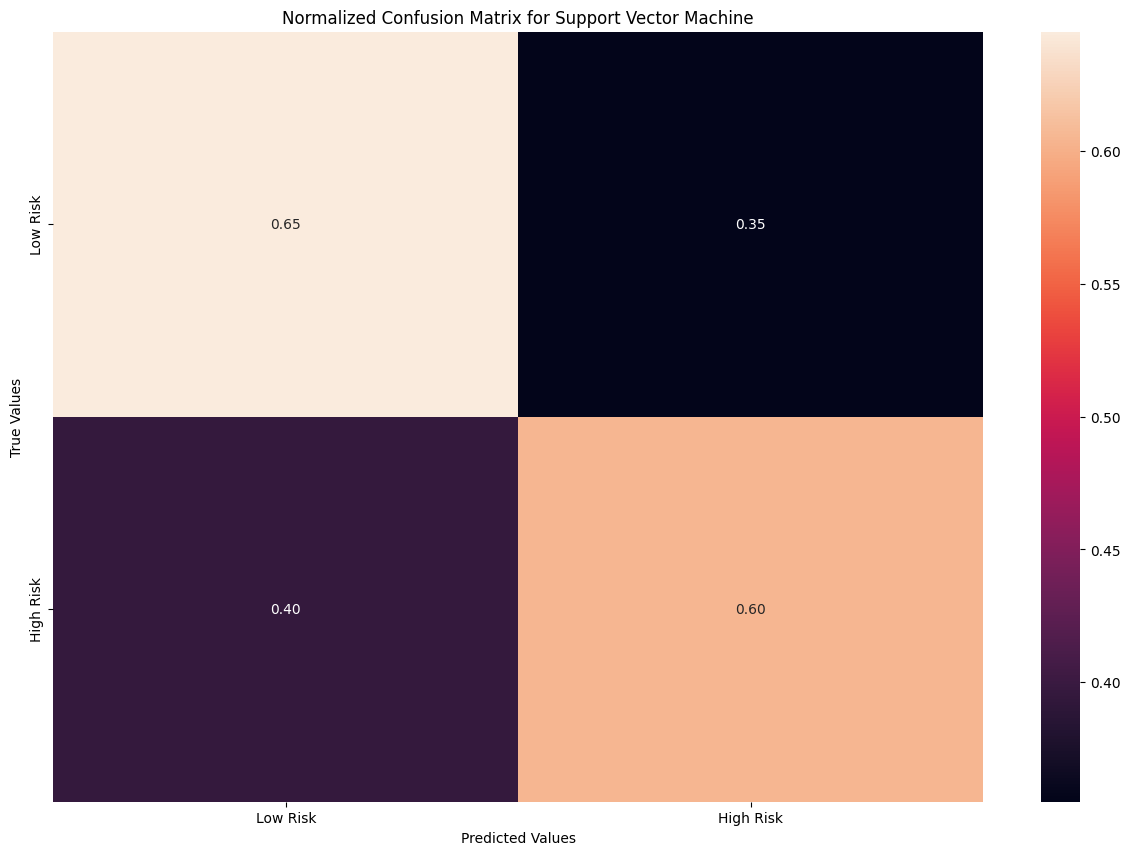

In [33]:
SVM_preds = SVM.predict(X_test)
SVM_summary = classification_report(y_true=y_test, y_pred=SVM_preds, labels=list(class_mapping.keys()), target_names=list(class_mapping.values()), output_dict=True)
print(f"Support Vector Machine Accuracy: {SVM_summary['accuracy']}")

SVM_file_name = "svm_performance"
dict_to_json(SVM_summary, Q3_DATA_PATH, SVM_file_name)

SVM_conmat = confusion_matrix(y_test, SVM_preds, normalize='true')

SVM_conmat_name = "svm_confusion_matrix"
SVM_model_name = "Support Vector Machine"
conmat_to_png(SVM_conmat, class_mapping, Q3_DATA_PATH, SVM_conmat_name, SVM_model_name)

**Model 3: Decision Tree**

Training

In [14]:
DTC = DecisionTreeClassifier(random_state=10, criterion="entropy", class_weight='balanced')
DTC.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,10
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


Evaluation

Decision Tree Accuracy: 0.5582
JSON file is saved to ..\assets\q3_data\dtc_performance.json!
PNG file is saved to ..\assets\q3_data\dtc_confusion_matrix.png!


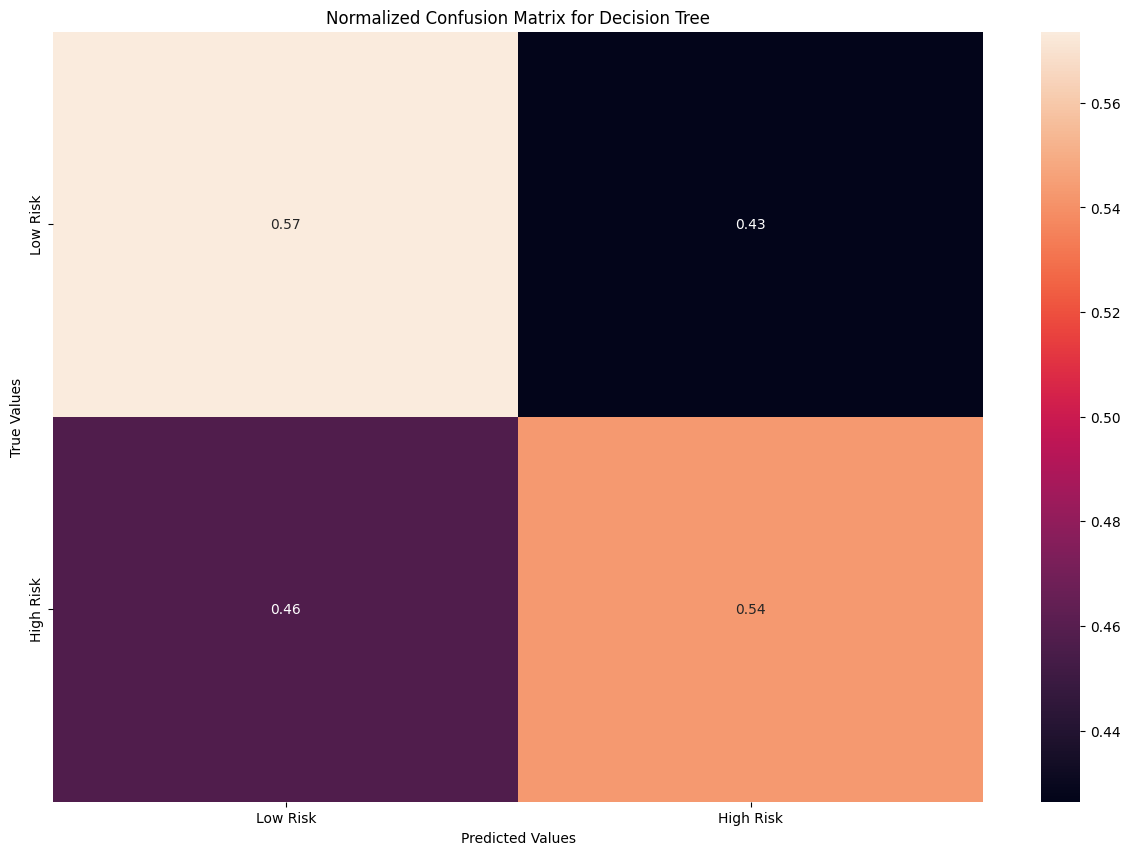

In [15]:
DTC_preds = DTC.predict(X_test)
DTC_summary = classification_report(y_true=y_test, y_pred=DTC_preds, labels=list(class_mapping.keys()), target_names=list(class_mapping.values()), output_dict=True)
print(f"Decision Tree Accuracy: {DTC_summary['accuracy']}")

DTC_file_name = "dtc_performance"
dict_to_json(DTC_summary, Q3_DATA_PATH, DTC_file_name)

DTC_conmat = confusion_matrix(y_test, DTC_preds, normalize='true')

DTC_conmat_name = "dtc_confusion_matrix"
DTC_model_name = "Decision Tree"
conmat_to_png(DTC_conmat, class_mapping, Q3_DATA_PATH, DTC_conmat_name, DTC_model_name)

Plot and Save Tree

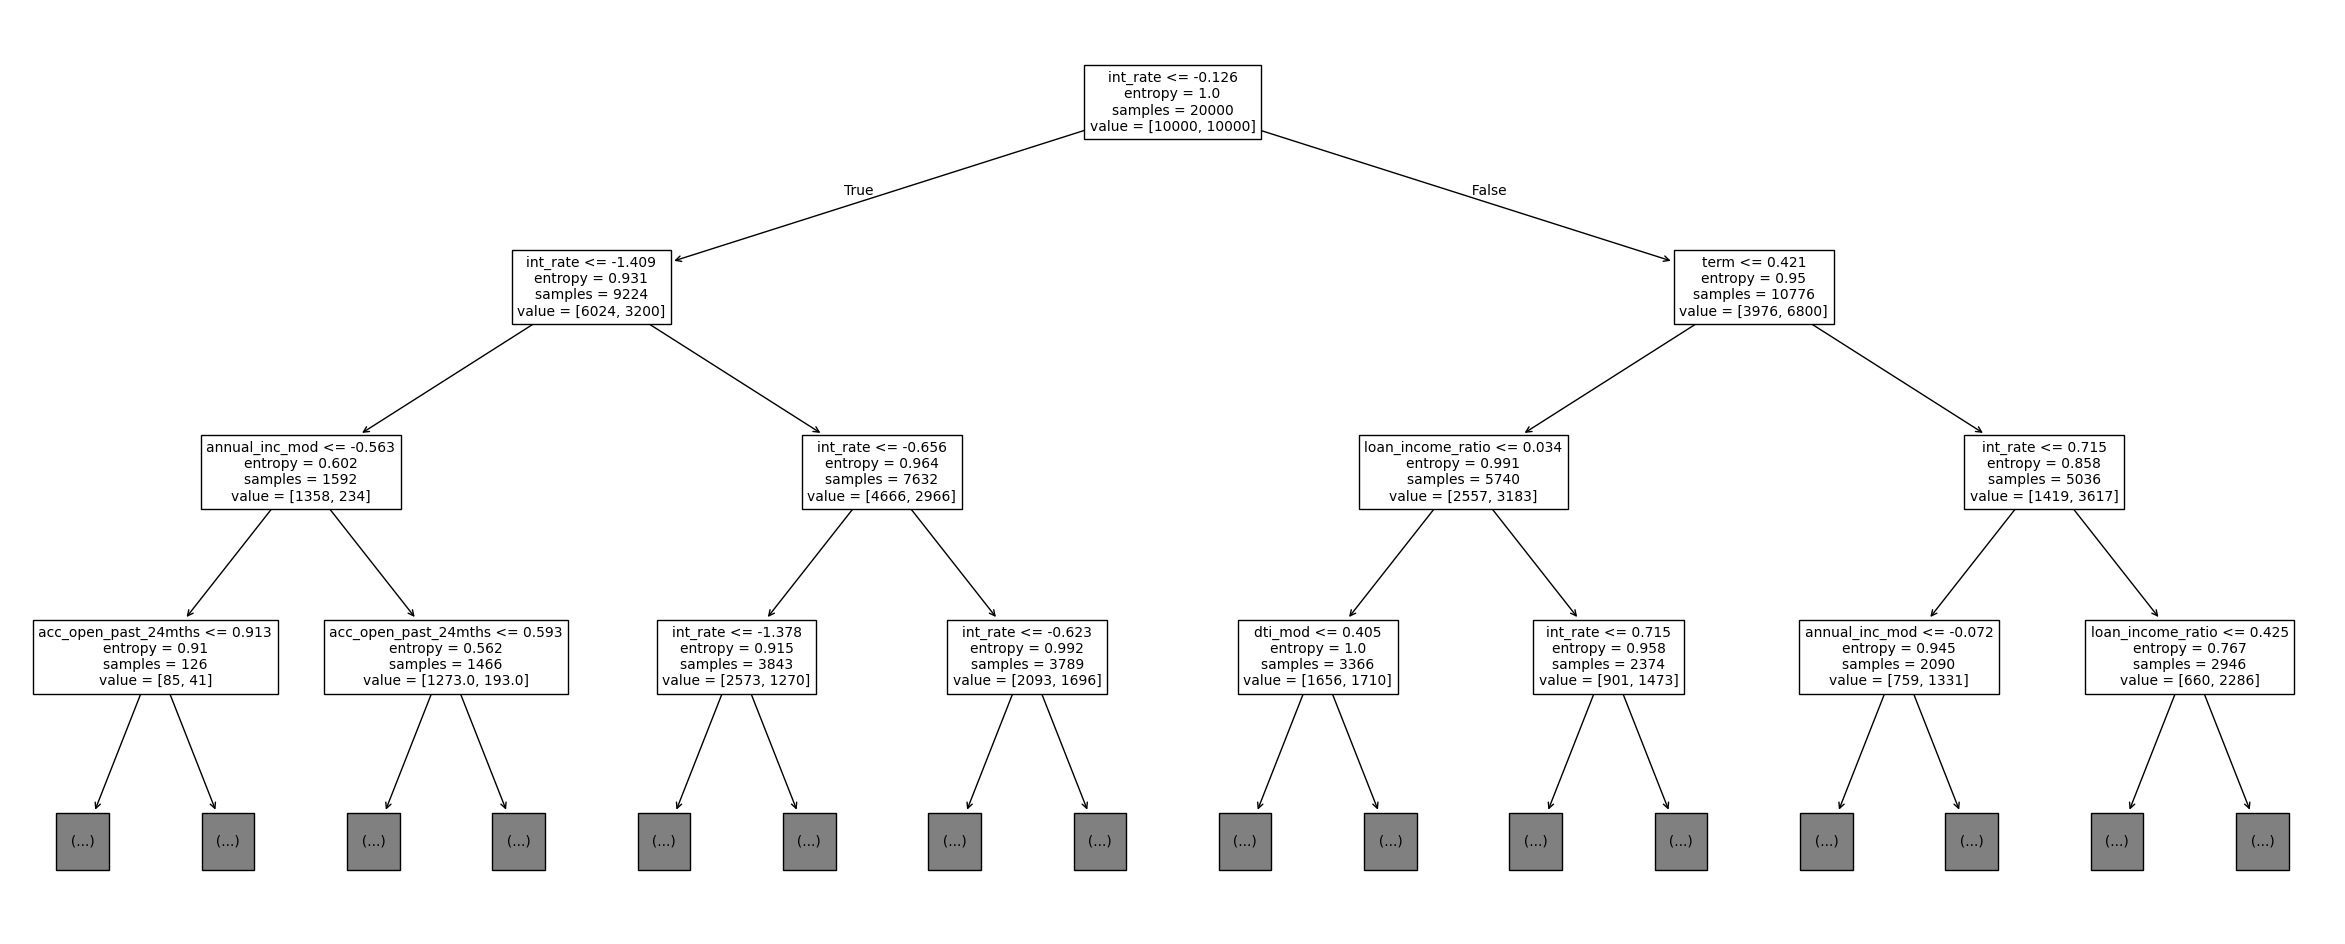

In [16]:
fig = plt.figure(figsize=(30,12))

plot_tree(decision_tree=DTC, max_depth=3, fontsize=10, feature_names=feature_names)

DTC_tree_name = "dtc_tree.png"
DTC_tree_path = os.path.join(Q3_DATA_PATH, DTC_tree_name)
os.makedirs(Q3_DATA_PATH, exist_ok=True)

fig.savefig(DTC_tree_path) 

**Model 4: K-Nearest Neighbours**

Training

In [21]:
K_vals = [1, 5, 10, 15, 20]
best_accuracy = 0
best_KNN = KNeighborsClassifier(n_neighbors=1)
best_K = 0
KNN_accuracies = []

for i in range(len(K_vals)):
    KNN_candidate = KNeighborsClassifier(n_neighbors=K_vals[i])

    KNN_candidate.fit(X_train, y_train)
    KNN_candidate_preds = KNN_candidate.predict(X_test)

    KNN_candidate_acc = round(accuracy_score(y_test, KNN_candidate_preds), 2)
    KNN_accuracies.append(KNN_candidate_acc)

    if KNN_candidate_acc > best_accuracy:
        best_KNN = KNN_candidate
        best_K = K_vals[i]
        best_accuracy = KNN_candidate_acc

KNN = best_KNN

print(f"Best K Value: {best_K}")
print(f"Accuracy: {best_accuracy}")

Best K Value: 15
Accuracy: 0.61


In [22]:
KNN_explore_dict = {
    'K': K_vals,
    'accuracies': KNN_accuracies
}

KNN_exp_file_name = "knn_exploration"
dict_to_json(KNN_explore_dict, Q3_DATA_PATH, KNN_exp_file_name)

JSON file is saved to ..\assets\q3_data\knn_exploration.json!


Evaluation

K-Nearest Neighbours Accuracy: 0.6062666666666666
JSON file is saved to ..\assets\q3_data\knn_performance.json!
PNG file is saved to ..\assets\q3_data\knn_confusion_matrix.png!


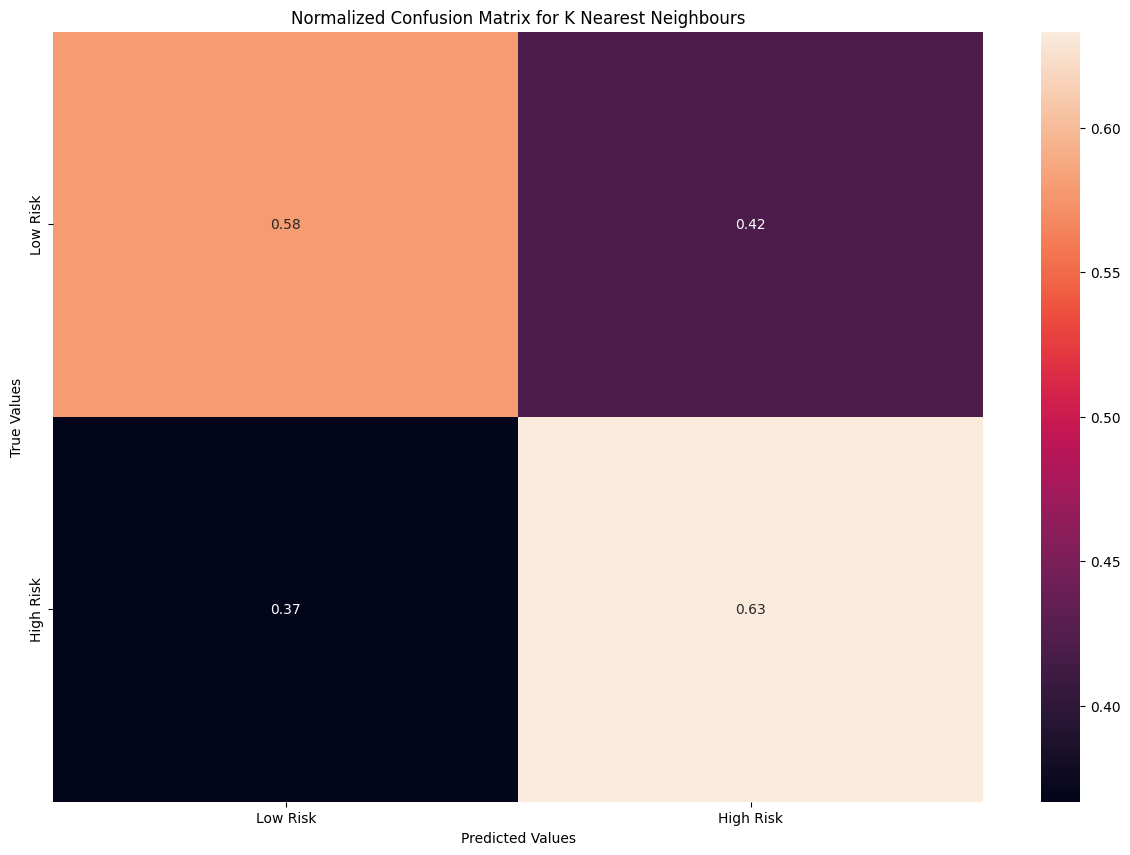

In [23]:
KNN_preds = KNN.predict(X_test)
KNN_summary = classification_report(y_true=y_test, y_pred=KNN_preds, labels=list(class_mapping.keys()), target_names=list(class_mapping.values()), output_dict=True)
print(f"K-Nearest Neighbours Accuracy: {KNN_summary['accuracy']}")

KNN_file_name = "knn_performance"
dict_to_json(KNN_summary, Q3_DATA_PATH, KNN_file_name)

KNN_conmat = confusion_matrix(y_test, KNN_preds, normalize='true')

KNN_conmat_name = "knn_confusion_matrix"
KNN_model_name = "K Nearest Neighbours"
conmat_to_png(KNN_conmat, class_mapping, Q3_DATA_PATH, KNN_conmat_name, KNN_model_name)

**Model 5: Neural Net**

**Prerequisites**

In [17]:
import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

Training

*Where the best model state is extracted from the best performing epoch with the lowest validation loss*

In [18]:
input_size = X_train_tensor.shape[1]
num_epochs = 1000
valid_split = 0.2
NN = BinaryClassifier(input_size)
NN.fit(X_train_tensor, y_train_tensor, num_epochs, valid_split)

Epoch [5/1000], Training Loss: 0.7030, Validation Loss: 0.7014
Epoch [10/1000], Training Loss: 0.7012, Validation Loss: 0.6999
Epoch [15/1000], Training Loss: 0.6999, Validation Loss: 0.6983
Epoch [20/1000], Training Loss: 0.6982, Validation Loss: 0.6968
Epoch [25/1000], Training Loss: 0.6969, Validation Loss: 0.6954
Epoch [30/1000], Training Loss: 0.6951, Validation Loss: 0.6939
Epoch [35/1000], Training Loss: 0.6942, Validation Loss: 0.6925
Epoch [40/1000], Training Loss: 0.6926, Validation Loss: 0.6911
Epoch [45/1000], Training Loss: 0.6909, Validation Loss: 0.6897
Epoch [50/1000], Training Loss: 0.6900, Validation Loss: 0.6883
Epoch [55/1000], Training Loss: 0.6887, Validation Loss: 0.6868
Epoch [60/1000], Training Loss: 0.6872, Validation Loss: 0.6854
Epoch [65/1000], Training Loss: 0.6859, Validation Loss: 0.6839
Epoch [70/1000], Training Loss: 0.6847, Validation Loss: 0.6824
Epoch [75/1000], Training Loss: 0.6831, Validation Loss: 0.6809
Epoch [80/1000], Training Loss: 0.6817, V

Evaluation

Neural Network Accuracy: 0.6264
JSON file is saved to ..\assets\q3_data\nn_performance.json!
PNG file is saved to ..\assets\q3_data\nn_confusion_matrix.png!
Neural Network Details Saved in ..\assets\q3_data\nn_details.txt!


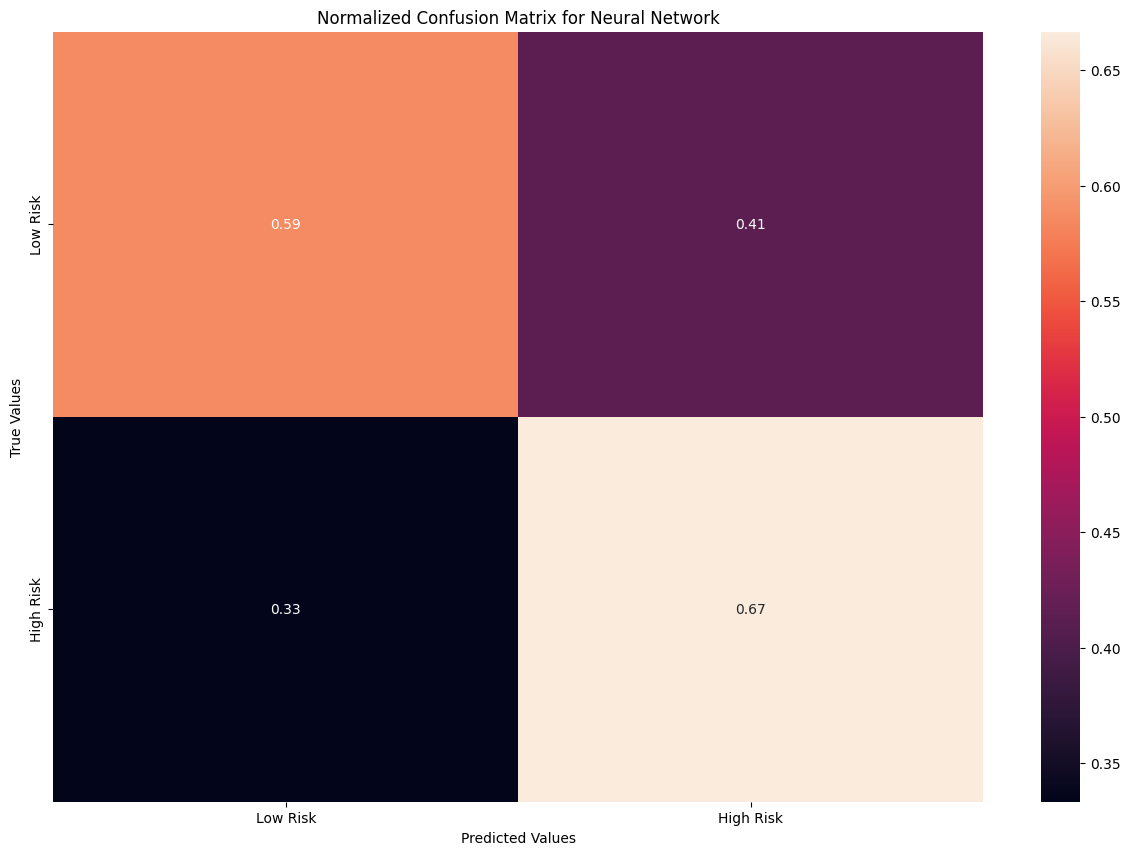

In [20]:
NN_preds = NN.predict(X_test_tensor)
NN_summary = classification_report(y_true=y_test_tensor, y_pred=NN_preds, labels=list(class_mapping.keys()), target_names=list(class_mapping.values()), output_dict=True)

print(f"Neural Network Accuracy: {NN_summary['accuracy']}")

NN_file_name = "nn_performance"
dict_to_json(NN_summary, Q3_DATA_PATH, NN_file_name)

NN_conmat = confusion_matrix(y_test, NN_preds, normalize='true')

NN_conmat_name = "nn_confusion_matrix"
NN_model_name = "Neural Network"
conmat_to_png(NN_conmat, class_mapping, Q3_DATA_PATH, NN_conmat_name, NN_model_name)

NN_details_file_name = "nn_details"
NN.print_model_summary(Q3_DATA_PATH, NN_details_file_name)